<a href="https://colab.research.google.com/github/Riddeekal/Deep_Learning_Course-WS19_20/blob/master/dl05_se.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning Lab 05 - Convolutional Neural Networks
# Building ConvNets for Image Classification

Welcome to the DL Lab 05! In this exercise, we will build a Convolutional Neural Network (aka 'ConvNet'/'CNN') for classifying 10 plant species by images of their flowers. In detail, we will perform the following steps:
1. Explore and Preprocess the data
2. Build a ConvNet from scratch
3. Evaluate training and validation accuracy
4. Investigate regularization techniques

**Note**: Training a ConvNet is a computationally expensive process. Most of the computations can be parallelized very efficently, making them a perfect fit for GPU- or TPU-acceleration. In order to enable a GPU for your Colab session, do the following steps:
- Click `Runtime` -> `Change runtime type`
- In the pop-up window, select `GPU` for `Hardware accelerator`
- Click `Save`

# 0 - Test for GPU

<font color='red'>
**Note**: CUDA was recently updated to version 10.1 at Google Colab. The current stable version of TensorFlow 2 (TF2) does not support CUDA 10.1. We have to use the nightly preview of TF2. Run

`!pip install tf-nightly-gpu`

and execute the code below for printing the TF version and testing for GPU availability.
</font>

In [0]:
!pip install tf-nightly-gpu

     |████████████████████████████████| 402.8MB 40kB/s 
     |████████████████████████████████| 450kB 47.7MB/s 
     |████████████████████████████████| 3.8MB 48.9MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
ERROR: tb-nightly 2.1.0a20191127 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [0]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow version: 2.1.0-dev20191127
Found GPU at: /device:GPU:0


# 1 - Explore and Preprocess the Data

## 1.1 - Download and Plot the Data

We'll start by downloading our dataset, composed of 1000 JPG images contained in a zip archive. Execute the code below for downloading and extracting the data to `/tmp/flowers10.zip`.

In [0]:
#@title Dataset Downloader
import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
def unzip(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

download_file_from_google_drive('1N4hmUQDJuimnB-98l8NGrNMo7eghNN1Y', '/tmp/flowers10.zip')
unzip('/tmp/flowers10.zip')

The base directory `/tmp/flowers10` contains the `train` and `val` subdirectories for the training and validation splits. Let's define each of these directories:

In [0]:
base_dir = '/tmp/flowers10/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Let's find out the number of images and classes:

In [0]:
#@title Print Dataset Statistics

import glob
import numpy as np

train_images = glob.glob(os.path.join(train_dir,'*', '*.jpg'))
validation_images = glob.glob(os.path.join(validation_dir,'*', '*.jpg'))

train_classes = [os.path.basename(os.path.dirname(x)) for x in train_images]
validation_classes = [os.path.basename(os.path.dirname(x)) for x in validation_images]

assert len(set(train_classes))==len(set(validation_classes)), 'Class mismatch between train and val'
classes = set(train_classes)
num_classes = len(classes)

for class_ in classes:
  print('Class: {}, training images: {}, validation images: {}'.format(class_, train_classes.count(class_), validation_classes.count(class_)))
print('\nTotal training images:', len(train_images))
print('Total validation images:', len(validation_images))
print('Number of classes:', num_classes)

Class: 7, training images: 80, validation images: 20
Class: 259, training images: 80, validation images: 20
Class: 141, training images: 80, validation images: 20
Class: 85, training images: 80, validation images: 20
Class: 60, training images: 80, validation images: 20
Class: 129, training images: 80, validation images: 20
Class: 117, training images: 80, validation images: 20
Class: 38, training images: 80, validation images: 20
Class: 156, training images: 80, validation images: 20
Class: 21, training images: 80, validation images: 20

Total training images: 800
Total validation images: 200
Number of classes: 10


We inspect few images to get a better sense of what the flowers look like:

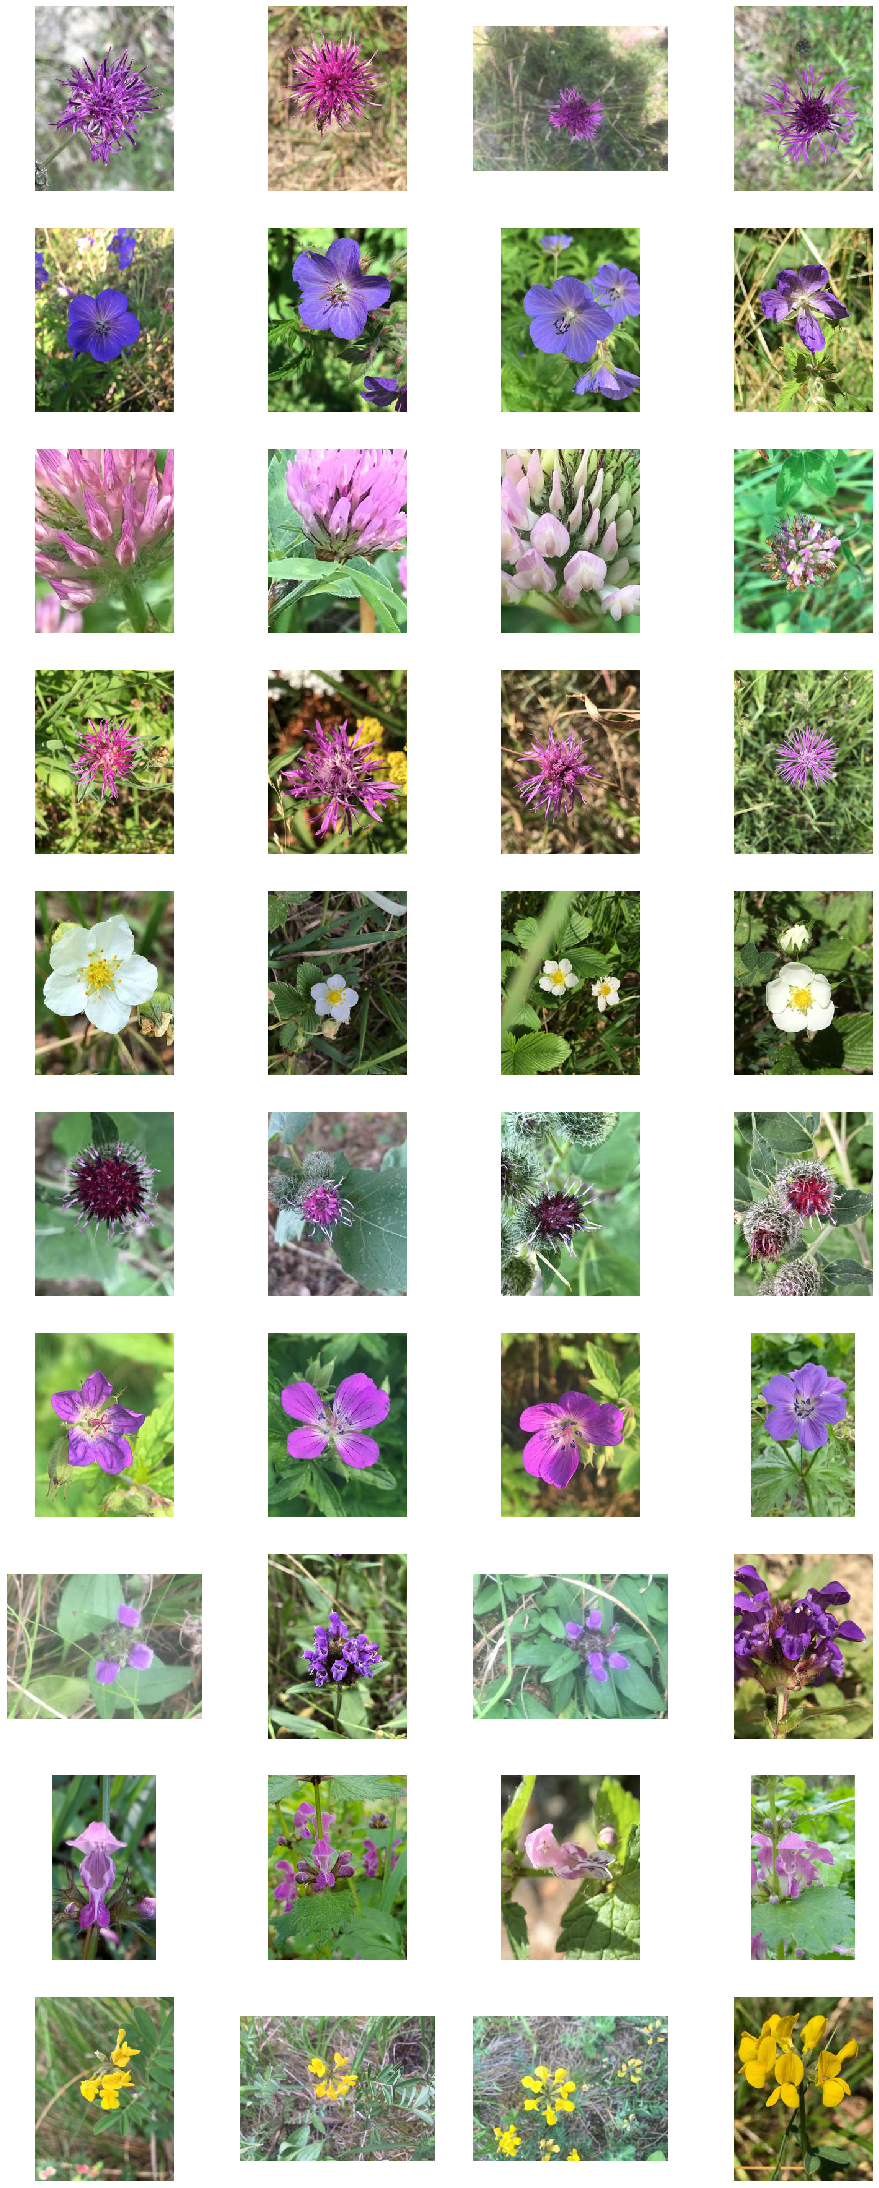

In [0]:
#@title Plot images
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = num_classes
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for row, class_ in enumerate(classes):
  class_images = [img for img,label in zip(validation_images, validation_classes) if label==class_]
  for col in range(ncols):
    sp = plt.subplot(nrows, ncols, row*ncols+col+1)
    sp.axis('Off')
    img = mpimg.imread(class_images[col])
    plt.imshow(img)
    
plt.show()

## 1.2 - Data Preprocessing

In contrast to the last labs, the dataset is composed of the original image files instead of one numpy array held in the memory. In addition, the image sizes likely won't fit the input specifications of the ConvNet we will design later.

In order to actually load the images to (GPU) memory, we will set up *data generators* that will 
1. read images from the source directories,
2. convert them to `float32` tensors,
3. and feed them (along with their labels) to our ConvNet.

We will have *one generator for the training images* and *one for the validation images*. 
The generators yield batches of 128 images with shape `(128, 150, 150, 3)` and their one-hot encoded labels.
In addition, we'll normalize the pixel values to `[0,1]` range using the `rescale` argument.

**Task**: Complete the code below according to the input specifications defined in the text.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128 # TODO 1

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
# Note: the `target_size` only refers to (width, height) of an image
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150,150 ), # TODO 2
                    batch_size=batch_size,
                    class_mode='categorical')

# Flow validation images in batches of 128 using val_datagen generator
# Note: the `target_size` only refers to (width, height) of an image
validation_generator = val_datagen.flow_from_directory(
                    validation_dir,
                    target_size=(150,150 ), # TODO 2
                    batch_size=batch_size,
                    class_mode='categorical')

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


Let's have a look on one batch, which itself is a `tuple([x], [y])`:

In [0]:
batch = validation_generator.next()
for label_el, batch_el in zip(('x','y'), batch):
  print('{} shape: {}'.format(label_el, batch_el.shape))
  print('{} example: {}'.format(label_el, batch_el[0]))
  print()
  
validation_generator.reset()

x shape: (128, 150, 150, 3)
x example: [[[0.69803923 0.7490196  0.47450984]
  [0.56078434 0.627451   0.34901962]
  [0.60784316 0.6745098  0.39607847]
  ...
  [0.3137255  0.43529415 0.27058825]
  [0.3254902  0.47450984 0.2901961 ]
  [0.27058825 0.41960788 0.23529413]]

 [[0.627451   0.6627451  0.40000004]
  [0.6039216  0.67058825 0.39607847]
  [0.5647059  0.6431373  0.3647059 ]
  ...
  [0.30588236 0.427451   0.2627451 ]
  [0.32156864 0.47058827 0.28627452]
  [0.25882354 0.40784317 0.22352943]]

 [[0.5803922  0.6039216  0.36078432]
  [0.60784316 0.6666667  0.4039216 ]
  [0.5372549  0.61960787 0.34901962]
  ...
  [0.31764707 0.427451   0.27058825]
  [0.3254902  0.4666667  0.28627452]
  [0.25882354 0.4039216  0.23137257]]

 ...

 [[0.40784317 0.47058827 0.35686275]
  [0.5294118  0.6        0.49803925]
  [0.5372549  0.62352943 0.53333336]
  ...
  [0.3254902  0.3372549  0.29411766]
  [0.24705884 0.24705884 0.20784315]
  [0.37254903 0.3529412  0.32941177]]

 [[0.38431376 0.44705886 0.33333334

# 2 - Build a ConvNet from Scratch
## 2.1 - Defining the Model Architecture

Let's code up the architecture. We'll stack **3 modules**, each constituted by a **convolution**, **ReLU**, and **maxpooling layer**. The convolutions operate on **3x3 windows** and the maxpooling layers operate on **2x2 windows**. The first convolution extracts **16 filters**, the following one extracts **32 filters**, and the last one extracts **64 filters**.

The output of the last maxpooling layer has the shape `(17, 17, 64)`. In order to feed this output into a fully-connected layer for classification, we need to transform it into a 1-dimensional vector. We can either flatten the output features using a `Flatten` layer by or max/mean pool features from the output them using a `GlobalMaxPooling2D` or `GlobalAveragePooling2D` layer.

We'll stick two fully-connected layers on top and use softmax activation at the end of the network since we are working on a multiclass classification task.

We will use Keras' Functional API to create the model in TensorFlow. The Functional API allows to create flexible models with non-linear topology, shared layers, as well as multiple inputs and/or outputs. The basic idea behind the Functional API is that a deep learning model is usually a directed acyclic graph of layers. Hence, Keras' Functional API is a set of tools for building graphs of layers.

If you want to read more about Keras and the Functional API, visit the [TensorFlow documentation](https://www.tensorflow.org/guide/keras/functional).

In [0]:
from tensorflow.keras import layers, Model

**Task**: Build the following model using Keras' Functional API.

**Hint**: The `layers` module provides all layers you need.

In [0]:
# TODO 3

# Our input is 150x150x3
input_img = layers.Input(shape=(150, 150, 3))

# First module: 16 filters, 3x3, relu, maxpool
### START YOUR CODE HERE ### (≈2 LOC)
x = layers.Conv2D(filters = 16, 
                  kernel_size=3, 
                  strides=(1,1), 
                  padding='valid',
                  activation='relu')(input_img)
x = layers.MaxPooling2D(2)(x)
### END YOUR CODE HERE ###

# Second convolution: 32 filters, 3x3, relu, maxpool
### START YOUR CODE HERE ### (≈2 LOC)
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=(1,1),
                  padding='valid',
                  activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

### END YOUR CODE HERE ###

# Third convolution: 64 filters, 3x3, relu, maxpool
### START YOUR CODE HERE ### (≈2 LOC)
x = layers.Conv2D(64, 3, activation='relu')(x)      
x = layers.MaxPooling2D(2)(x)
### END YOUR CODE HERE ###

# Flatten the feature map to a 1-dim tensor so we can add fully-connected layers
x = layers.GlobalMaxPooling2D()(x)

# Create the output layer with num_classes nodes and softmax activation
output = layers.Dense(num_classes, activation='softmax')(x)

# Finally, create the model by defining input and output layers
model = Model(input_img, output)

Keras provides the instance method `summary()` for printing the model architecture along with associated shapes and number of parameters per layer:

In [0]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

## 2.2 - Compiling the Model

We are now ready to compile our model. Compiling the model requires three parameters:
1. an optimizer,
2. a loss function, and
3. evaluation metrics.

The **optimizer** controls the learning rate. We will be using `Adam`, which adjusts the learning rate troughout the training process and is a very good optimizer to be used in many cases.

As we have a multiclass problem, we will use `categorical_crossentropy` as **loss function**. Please note that there's also a loss termed `sparse_categorical_crossentropy`, which is used if the training targets `y` are *integers* in contrast to *one-hot encoded* labels.

At last, we define `accuracy` as **metric** for assessing the performance of our ConvNet on the validation set during training.

In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0015),
              metrics=['accuracy'])

## 2.3 - Training the Model

Using the `fit_generator()` method, we can finally train our ConvNet on all training images, and validate at the end of each epoch on the validation images.

**Note**: If our dataset consisted of `X`, `Y` tensors completely stored in memory instead of loaded by generators, we would use the `fit()` method.

**Task**: Train the model for 30 epochs.

In [0]:
train_steps = np.ceil(train_generator.samples / train_generator.batch_size)  # 800 images = batch_size * steps
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)  # 200 images = batch_size * steps

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_steps,
      epochs= 30, # TODO 5
      validation_data=validation_generator,
      validation_steps=val_steps,
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7.0 steps, validate for 2.0 steps
Epoch 1/30
7/7 - 5s - loss: 2.2950 - accuracy: 0.1475 - val_loss: 2.2558 - val_accuracy: 0.3100
Epoch 2/30
7/7 - 1s - loss: 2.2135 - accuracy: 0.2975 - val_loss: 2.1425 - val_accuracy: 0.3350
Epoch 3/30
7/7 - 1s - loss: 2.0384 - accuracy: 0.3850 - val_loss: 1.8962 - val_accuracy: 0.4300
Epoch 4/30
7/7 - 1s - loss: 1.7327 - accuracy: 0.5188 - val_loss: 1.5999 - val_accuracy: 0.5450
Epoch 5/30
7/7 - 1s - loss: 1.4007 - accuracy: 0.6025 - val_loss: 1.3197 - val_accuracy: 0.6100
Epoch 6/30
7/7 - 1s - loss: 1.1749 - accuracy: 0.6175 - val_loss: 1.1327 - val_accuracy: 0.6250
Epoch 7/30
7/7 - 1s - loss: 1.0213 - accuracy: 0.6712 - val_loss: 1.0361 - val_accuracy: 0.6700
Epoch 8/30
7/7 - 1s - loss: 0.8717 - accuracy: 0.7275 - val_loss: 0.9309 - val_accuracy: 0.7100
Epoch 9/30
7/7 - 1s - loss: 0.7872 - accuracy: 0.7613 - val_lo

# 3 - Evaluating Accuracy and Loss for the Model
The `fit_generator()` and `fit()` method of the model return the history of the training process, containing the loss and metric(s) as we defined them during model compilation.

Let's plot the training/validation accuracy and loss as collected during training.

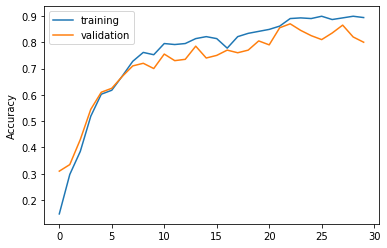

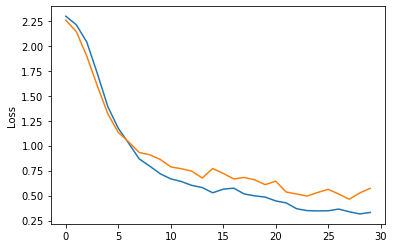

In [0]:
#@title Plot history

def plot_history(history):
  # Retrieve a list of accuracy results on training and test data sets for each training epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get number of epochs
  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc)
  plt.plot(epochs, val_acc)
  plt.ylabel('Accuracy')
  #plt.title('Training and validation accuracy')
  plt.legend( ('training', 'validation') )
  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  plt.ylabel('Loss')
  #plt.yscale('log')
  #plt.title('Training and validation loss')
  
  
plot_history(history)

**Congratulations**, you built and trained your first CNN and achieved >80% accuracy! However, we can conclude some findings by interpreting the learning curves:

- The accuracy on the training dataset slowly converges towards 1. This indicates that our model capacity might be too small to fit the data well enough.

- The accuracy and loss on the validation data start to diverge from the curves of the training data. This indicates that our model has problems in generalizing from training data to validation data.

*Which design tricks do you remember from the lecture? E.g., for effectivly increasing the perceptive field?*

---

#4 - Reducing Overfitting
Here, we'll add three common strategies to our model in order to reduce overfitting and improve generalization by regularization:
- data augmentation and shuffling
- batch normalization.

## Exploring Data Augmentation
In order to make most of our few training examples, we'll augment them by a number of random transformations. During training, our model will **never** see the exact same picture again.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance.

In detail, we'll add following transformations:
- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `vertical_flip` is for randomly flipping half of the images vertically. This is relevant when there are no assumptions of vertical assymmetry (e.g. top-view images of flowers).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

**Note**: These are just a few of the options available. Check the [documentation](https://keras.io/preprocessing/image/) for more.

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150,150),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True,
                    seed=42)

Found 800 images belonging to 10 classes.


Note that we set `shuffle=True` in the `train_generator`. The training data is now shuffled after each epoch. This way, the network will never see the same mini-batch composition again, which ultimately avoids getting stuck in local minima.

Let's take a look at our augmented images!

In [0]:
#@title Plot Augmented Images


from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = train_images[int(np.random.random() * len(train_images))]
img = load_img(img_path, target_size=(150,150)) # PIL image
x = img_to_array(img) # Numpy array with shape (150,150,3)
x = x.reshape((1,) + x.shape) # Pseudo-batch, i.e., Numpy array with array (1,150,150,3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to break the loop...

n_runs = 5
fig = plt.gcf()
fig.set_size_inches(n_runs*4,4)

i=0
for batch in train_datagen.flow(x, batch_size=1):
  sp = plt.subplot(1, n_runs, i+1)
  sp.axis('Off')
  plt.imshow(array_to_img(batch[0]))
  i+=1
  if i % n_runs == 0:
    break
    
plt.show()

If we train a network using this data augmentation configuration, the network will never see the same input twice. However, the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to mitigate overfitting.

In [0]:
# TODO 6: define & compile model
### START YOUR CODE HERE ### (≈27 LOC)

# Our input is 150x150x3
input_img = layers.Input(shape=(150, 150, 3))

# First module: 16 filters, 3x3, relu, maxpool
x = layers.Conv2D(filters = 16, 
                  kernel_size=3, 
                  strides=(1,1), 
                  padding='valid',
                  activation='relu')(input_img)
x = layers.MaxPooling2D(2)(x)
### END YOUR CODE HERE ###

# Second convolution: 32 filters, 3x3, relu, maxpool
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=(1,1),
                  padding='valid',
                  activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution: 64 filters, 3x3, relu, maxpool
x = layers.Conv2D(64, 3, activation='relu')(x)      
x = layers.MaxPooling2D(2)(x)

# Flatten the feature map to a 1-dim tensor so we can add fully-connected layers
x = layers.GlobalMaxPooling2D()(x)

# Create the output layer with num_classes nodes and softmax activation
output = layers.Dense(num_classes, activation='softmax')(x)

# Finally, create the model by defining input and output layers
model = Model(input_img, output)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0015),
              metrics=['accuracy'])


### END YOUR CODE HERE ### 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7.0 steps, validate for 2.0 steps
Epoch 1/100
7/7 - 5s - loss: 2.3154 - accuracy: 0.1100 - val_loss: 2.2860 - val_accuracy: 0.1800
Epoch 2/100
7/7 - 4s - loss: 2.2655 - accuracy: 0.1787 - val_loss: 2.2390 - val_accuracy: 0.1800
Epoch 3/100
7/7 - 4s - loss: 2.1929 - accuracy: 0.1587 - val_loss: 2.1459 - val_accuracy: 0.1750
Epoch 4/100
7/7 - 4s - loss: 2.0850 - accuracy: 0.1975 - val_loss: 2.0449 - val_accuracy: 0.2300
Epoch 5/100
7/7 - 4s - loss: 1.9656 - accuracy: 0.2550 - val_loss: 1.9382 - val_accuracy: 0.3100
Epoch 6/100
7/7 - 4s - loss: 1.8647 - accuracy: 0.3237 - val_loss: 1.8320 - val_accuracy: 0.3500
Epoch 7/100
7/7 - 4s - loss: 1.7544 - accuracy: 0.3713 - val_loss: 1.7664 - val_accuracy: 0.4150
Epoch 8/100
7/7 - 4s - loss: 1.6255 - accuracy: 0.4137 - val_loss: 1.5985 - val_accuracy: 0.4300
Epoch 9/100
7/7 - 4s - loss: 1.5095 - accuracy: 0.4363 - val_loss: 1.4511 - val_accuracy: 0.5200
Epoch 10/100
7/7 - 4s - loss: 1.3

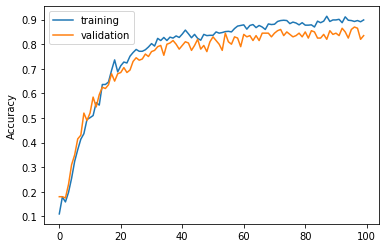

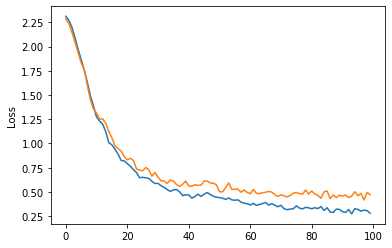

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=val_steps,
      verbose=2)

plot_history(history)

##Adding Batch Normalization
Another popular strategy for fighting overfitting is to use **batch normalization**.

Let's reconfigure our ConvNet architecture and add `BatchNormalization` layers, right after each convolutional layer.

In [0]:
# TODO 7: define & compile model
### START YOUR CODE HERE ### (≈31 LOC)

# Our input is 150x150x3
input_img = layers.Input(shape=(150, 150, 3))

# First module: 16 filters, 3x3, relu, maxpool
x = layers.Conv2D(filters = 16, 
                  kernel_size=3, 
                  strides=(1,1), 
                  padding='valid',
                  activation='relu')(input_img)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(2)(x)

# Second convolution: 32 filters, 3x3, relu, maxpool
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=(1,1),
                  padding='valid',
                  activation='relu')(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution: 64 filters, 3x3, relu, maxpool
x = layers.Conv2D(64, 3, activation='relu')(x)      
x = layers.MaxPooling2D(2)(x)

# Flatten the feature map to a 1-dim tensor so we can add fully-connected layers
x = layers.GlobalMaxPooling2D()(x)

# Create the output layer with num_classes nodes and softmax activation
output = layers.Dense(num_classes, activation='softmax')(x)

# Finally, create the model by defining input and output layers
model = Model(input_img, output)

# Finally, create the model by defining input and output layers and compile
model = Model(input_img, output)
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.003),
             metrics=['accuracy'])

### END YOUR CODE HERE ### 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7.0 steps, validate for 2.0 steps
Epoch 1/100
7/7 - 5s - loss: 3.2253 - accuracy: 0.2325 - val_loss: 2.3443 - val_accuracy: 0.1000
Epoch 2/100
7/7 - 4s - loss: 1.5400 - accuracy: 0.4137 - val_loss: 2.2919 - val_accuracy: 0.1050
Epoch 3/100
7/7 - 4s - loss: 1.2163 - accuracy: 0.5738 - val_loss: 2.2260 - val_accuracy: 0.1900
Epoch 4/100
7/7 - 4s - loss: 0.9901 - accuracy: 0.6700 - val_loss: 2.1743 - val_accuracy: 0.1500
Epoch 5/100
7/7 - 4s - loss: 0.7972 - accuracy: 0.7287 - val_loss: 2.0891 - val_accuracy: 0.2100
Epoch 6/100
7/7 - 4s - loss: 0.7212 - accuracy: 0.7513 - val_loss: 2.0358 - val_accuracy: 0.2300
Epoch 7/100
7/7 - 4s - loss: 0.6455 - accuracy: 0.7750 - val_loss: 1.9831 - val_accuracy: 0.3100
Epoch 8/100
7/7 - 4s - loss: 0.5270 - accuracy: 0.8112 - val_loss: 1.9832 - val_accuracy: 0.3050
Epoch 9/100
7/7 - 4s - loss: 0.5058 - accuracy: 0.8163 - val_loss: 1.9778 - val_accuracy: 0.3500
Epoch 10/100
7/7 - 4s - loss: 0.4

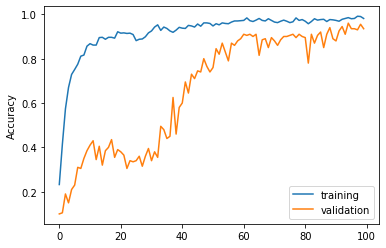

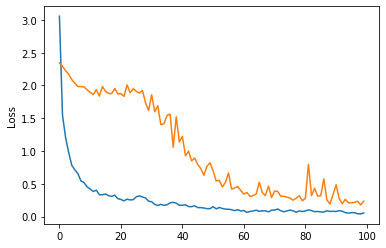

In [0]:
train_steps = np.ceil(train_generator.samples / train_generator.batch_size)  # 800 images = batch_size * steps
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)  # 200 images = batch_size * steps

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps,
    verbose=2)

plot_history(history)

Nice! We see no overfitting for 100 epochs and we have increased the validation accuracy. Judging by the training profile, we might continue training and probably further increase the accuracy.

In the next lab, we will discuss and perform transfer-learning and fine-tuning using bigger models.